In [1]:
import reciprocalspaceship as rs
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import gemmi as gm
import seaborn as sns
import re

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 18,
    #"font.family" : "sans-serif",
    #"font.sans-serif" : ["Nimbus Sans"],
}
plt.rcParams.update(new_rc_params)

directory_search_pattern ="careless_runs" 

pyp_yellow="#ab9020"
pyp_blue="#5ab3ab"

## Introduction

In this Jupyter notebook, we will compute merging statistics for careless outputs. We compute the $CC_{\text{1/2}}$ and $CC_\text{pred}$ using `careless.cchalf` and `careless.ccpred`, (Aldama et al. 2023), and we plot these values as a function of double-Wilson $r$. $CC_\text{pred}$ is the correlation coefficient between the observed and `careless`-predicted structure factors. and $CC_\text{1/2}$ is the correlation coefficient between random half-datasets (Aldama et al. 2023). After this, we construct a few schemes for weighting difference maps. The effect of these weighting schemes on the real-space correlation will be explored in the subsequent notebook, `PYP_diff_map_corr.ipynb`. 

In [2]:
def get_careless_params(dirpath):
#     print(os.path.join(dirpath, 'inputs_params.log'))
    with open(os.path.join(dirpath, 'inputs_params.log')) as params:
        line = params.readline()
        line = params.readline()
        args_list=line.split('--')
#             print(args_list)
        p_={}
        bDisableImageScale=False
        for tag in args_list:
            if 'dmin' in tag:
                p_['DMIN']=tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-frequencies' in tag:
                p_['PEF'] =tag.split('=')[1].split(' ')[0]
            if 'iterations' in tag:
                p_['ITER']=tag.split('=')[1].split(' ')[0]
            if 'mlp-layers' in tag:
                p_['MLPL']=tag.split('=')[1].split(' ')[0]
            if 'studentt-likelihood-dof' in tag:
                p_['STDOF'] =tag.split('=')[1].split(' ')[0]
            if 'image-layers' in tag:
                p_['IL']  =tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-keys' in tag:
                p_['PE-keys']=tag.split('=')[1].split(' ')[0]
            if 'seed' in tag:
                p_['SEED']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-parents' in tag:
                p_['DW_list']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-r' in tag:
                DWr_list = tag.split('=')[1]
                p_['rDW']  = DWr_list.split(',')[-1]
            if 'disable-image-scales' in tag:
                bDisableImageScale=True
            if 'refine-uncertainties' in tag:
                p_['RU']=1
        if bDisableImageScale:
            p_['IL']=-1
        if 'STDOF' not in p_:
            p_['STDOF']=-1
        if 'RU' not in p_:
            p_['RU']=0
        if 'PEF' not in p_:
            p_['PEF']=0
        if 'rDW' not in p_:
            p_['rDW']=-1
        run_param=pd.DataFrame(data=p_,index=[0])
        run_param.DMIN  = run_param.DMIN.astype( 'float')
        run_param.SEED  = run_param.SEED.astype( 'int64')
        run_param.ITER  = run_param.ITER.astype( 'int64')
        run_param.STDOF = run_param.STDOF.astype('float')
        run_param.RU    = run_param.RU.astype(   'int64')
        run_param.MLPL  = run_param.MLPL.astype( 'int64')
        run_param.IL    = run_param.IL.astype(   'int64')
        run_param.rDW   = run_param.rDW.astype(  'float')
        run_param.PEF   = run_param.PEF.astype(  'int64')
        return run_param

### Importing $CC_\text{pred}$

In [22]:
!pwd

/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/pyp


In [23]:
%%bash

sh ./run_ccs.sh merge_2104*

careless_runs/merge_21040353_6414_poly_mc1_50k_cl3_grid_16
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/pyp/careless_runs/merge_21040353_6414_poly_mc1_50k_cl3_grid_16
1
careless_runs/merge_21040354_27718_poly_mc1_50k_cl3_grid_2
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/pyp/careless_runs/merge_21040354_27718_poly_mc1_50k_cl3_grid_2

careless_runs/merge_21040355_26_poly_mc1_50k_cl3_grid_3
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/pyp/careless_runs/merge_21040355_26_poly_mc1_50k_cl3_grid_3

careless_runs/merge_21040414_1740_poly_mc1_50k_cl3_grid_4
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/pyp/careless_runs/merge_21040414_1740_poly_mc1_50k_cl3_grid_4

careless_runs/merge_21040415_28650_poly_mc1_50k_cl3_grid_5
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/pyp/careless_runs/merge_21040415_28650_poly_mc1_50k_cl3_grid_5

careless_runs/merge_21040416_14464_poly_mc1_50k_cl3_grid_6
/net/hol

In [3]:
count=0
results_list=[]
params_list=[]
id_list=[]


for dirpath, dirnames, filenames in os.walk("."):
    if ('ccpred_overall_careless.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccpred_overall_careless.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-8]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-7])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
        careless_params=get_careless_params(dirpath)
        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
        careless_params["seed"]=seed
        params_list.append(careless_params)

all_params =pd.concat(params_list)
all_results_ccpred=pd.concat(results_list)

./careless_runs/merge_21040353_6414_poly_mc1_50k_cl3_grid_16
Read-in values of grid_id: 16,  job_id: 21040353,  seed: 6414
./careless_runs/merge_21040414_1740_poly_mc1_50k_cl3_grid_4
Read-in values of grid_id: 4,  job_id: 21040414,  seed: 1740
./careless_runs/merge_21040418_16432_poly_mc1_50k_cl3_grid_8
Read-in values of grid_id: 8,  job_id: 21040418,  seed: 16432
./careless_runs/merge_21040420_21111_poly_mc1_50k_cl3_grid_10
Read-in values of grid_id: 10,  job_id: 21040420,  seed: 21111
./careless_runs/merge_21040355_26_poly_mc1_50k_cl3_grid_3
Read-in values of grid_id: 3,  job_id: 21040355,  seed: 26
./careless_runs/merge_21040537_31377_poly_mc1_50k_cl3_grid_12
Read-in values of grid_id: 12,  job_id: 21040537,  seed: 31377
./careless_runs/merge_21040637_8951_poly_mc1_50k_cl3_grid_15
Read-in values of grid_id: 15,  job_id: 21040637,  seed: 8951
./careless_runs/merge_21040415_28650_poly_mc1_50k_cl3_grid_5
Read-in values of grid_id: 5,  job_id: 21040415,  seed: 28650
./careless_runs/merg

### Importing $CC_\text{1/2}$

In [4]:
results_list=[]
for dirpath, dirnames, filenames in os.walk("."):
    if ('cchalf_overall.csv' in filenames) and (directory_search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'cchalf_overall.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-8]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-7])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
all_results_cchalf=pd.concat(results_list)

./careless_runs/merge_21040353_6414_poly_mc1_50k_cl3_grid_16
Read-in values of grid_id: 16,  job_id: 21040353,  seed: 6414
./careless_runs/merge_21040414_1740_poly_mc1_50k_cl3_grid_4
Read-in values of grid_id: 4,  job_id: 21040414,  seed: 1740
./careless_runs/merge_21040418_16432_poly_mc1_50k_cl3_grid_8
Read-in values of grid_id: 8,  job_id: 21040418,  seed: 16432
./careless_runs/merge_21040420_21111_poly_mc1_50k_cl3_grid_10
Read-in values of grid_id: 10,  job_id: 21040420,  seed: 21111
./careless_runs/merge_21040355_26_poly_mc1_50k_cl3_grid_3
Read-in values of grid_id: 3,  job_id: 21040355,  seed: 26
./careless_runs/merge_21040537_31377_poly_mc1_50k_cl3_grid_12
Read-in values of grid_id: 12,  job_id: 21040537,  seed: 31377
./careless_runs/merge_21040637_8951_poly_mc1_50k_cl3_grid_15
Read-in values of grid_id: 15,  job_id: 21040637,  seed: 8951
./careless_runs/merge_21040415_28650_poly_mc1_50k_cl3_grid_5
Read-in values of grid_id: 5,  job_id: 21040415,  seed: 28650
./careless_runs/merg

In [5]:
all_params.reset_index(drop=True,inplace=True)
#all_params.info()
all_params.head(10)

,MLPL,IL,DMIN,ITER,SEED,STDOF,RU,PEF,rDW,grid_id,job_id,seed,DW_list
0,10,0,1.6,50000,6414,32.0,0,0,-1.00000,16,21040353,6414,NaN
1,10,0,1.6,50000,1740,32.0,0,0,0.75000,4,21040414,1740,"None,0"
2,10,0,1.6,50000,16432,32.0,0,0,0.98438,8,21040418,16432,"None,0"
3,10,0,1.6,50000,21111,32.0,0,0,0.99609,10,21040420,21111,"None,0"
4,10,0,1.6,50000,26,32.0,0,0,0.50000,3,21040355,26,"None,0"
5,10,0,1.6,50000,31377,32.0,0,0,0.99902,12,21040537,31377,"None,0"
6,10,0,1.6,50000,8951,32.0,0,0,0.99990,15,21040637,8951,"None,0"
7,10,0,1.6,50000,28650,32.0,0,0,0.87500,5,21040415,28650,"None,0"
8,10,0,1.6,50000,14369,32.0,0,0,0.96875,7,21040417,14369,"None,0"
9,10,0,1.6,50000,9267,32.0,0,0,0.99219,9,21040419,9267,"None,0"


In [6]:
all_results_ccpred.head()

,Unnamed: 0,file,Resolution Range (Å),bin,test,Spacegroup,CCpred,grid_id,job_id,seed
0,0,pyp_1p6A_grid_predictions_0.mtz,19.31 - 1.60,0,Train,P 63,0.961503,16,21040353,6414
1,1,pyp_1p6A_grid_predictions_0.mtz,19.31 - 1.60,0,Test,P 63,0.924392,16,21040353,6414
2,2,pyp_1p6A_grid_predictions_1.mtz,19.31 - 1.60,0,Train,P 63,0.961425,16,21040353,6414
3,3,pyp_1p6A_grid_predictions_1.mtz,19.31 - 1.60,0,Test,P 63,0.912312,16,21040353,6414
0,0,pyp_1p6A_grid_predictions_0.mtz,19.31 - 1.60,0,Train,P 63,0.961184,4,21040414,1740


In [7]:
all_results_ccpred = pd.melt(all_results_ccpred, id_vars=['file', 'grid_id','job_id','Resolution Range (Å)','seed','test'], value_vars=['CCpred'])
all_results_ccpred.rename(columns={'value': 'CCpred'}, inplace=True)
pivoted_df = all_results_ccpred.pivot(index=['file', 'grid_id','job_id','Resolution Range (Å)','seed'], columns='test', values='CCpred')
pivoted_df.rename(columns={'Test': 'CCpred_test','Train': 'CCpred_train'}, inplace=True)
all_results_ccpred = pivoted_df.reset_index()

In [8]:
all_params.reset_index(drop=True,inplace=True)
all_results_ccpred.dropna(inplace=True)
all_results_ccpred["delay"] = [name[-5] for name in all_results_ccpred.file]
all_results_ccpred["delay"]=all_results_ccpred["delay"].astype('int32')
all_results_ccpred.sort_values(by=["grid_id","job_id"],inplace=True)
all_results_ccpred.reset_index(inplace=True)
print(all_results_ccpred.count())
all_results_ccpred.head()

test
index                   30
file                    30
grid_id                 30
job_id                  30
Resolution Range (Å)    30
seed                    30
CCpred_test             30
CCpred_train            30
delay                   30
dtype: int64


test,index,file,grid_id,job_id,Resolution Range (Å),seed,CCpred_test,CCpred_train,delay
0,0,pyp_1p6A_grid_predictions_0.mtz,2,21040354,19.31 - 1.60,27718,0.915706,0.963159,0
1,15,pyp_1p6A_grid_predictions_1.mtz,2,21040354,19.31 - 1.60,27718,0.916208,0.959979,1
2,1,pyp_1p6A_grid_predictions_0.mtz,3,21040355,19.31 - 1.60,26,0.922296,0.962357,0
3,16,pyp_1p6A_grid_predictions_1.mtz,3,21040355,19.31 - 1.60,26,0.925156,0.960687,1
4,2,pyp_1p6A_grid_predictions_0.mtz,4,21040414,19.31 - 1.60,1740,0.930081,0.961184,0


### Clean `cchalf` table for merging

In [9]:
#all_results_cchalf1 = all_results_cchalf.groupby(by=["seed","Spacegroup","bin"]).agg({'CChalf':['mean','std']}).reset_index(drop=True)
all_results_cchalf1 = all_results_cchalf[["CChalf","grid_id","seed","Spacegroup","bin"]]
all_results_cchalf1 = all_results_cchalf1.groupby(by=["seed","Spacegroup","bin"]).mean().reset_index(drop=True)
all_results_cchalf1["grid_id"]=all_results_cchalf1["grid_id"].astype("int32")


In [10]:
all_results = all_results_ccpred.merge(all_results_cchalf1,on="grid_id")

In [11]:
all_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 30 non-null     int64  
 1   file                  30 non-null     object 
 2   grid_id               30 non-null     int64  
 3   job_id                30 non-null     int64  
 4   Resolution Range (Å)  30 non-null     object 
 5   seed                  30 non-null     int64  
 6   CCpred_test           30 non-null     float64
 7   CCpred_train          30 non-null     float64
 8   delay                 30 non-null     int32  
 9   CChalf                30 non-null     float64
dtypes: float64(3), int32(1), int64(4), object(2)
memory usage: 2.4+ KB


In [12]:
df_param=all_params[['IL','MLPL','ITER','STDOF','PEF','rDW','RU','grid_id','job_id','seed']].copy()

for ix, row in df_param.iterrows():
    grid_id=int(row["grid_id"])
    job_id =int(row["job_id"])
    for column in df_param.columns:
        all_results.loc[(all_results["grid_id"]==grid_id) & (all_results["job_id"]==job_id), column] =\
        df_param.loc[(df_param["grid_id"]==grid_id) & (df_param["job_id"]==job_id),column].to_numpy()[0]

all_results=all_results.infer_objects()
all_results=all_results.sort_values(by=["grid_id"])

tmp=all_results.loc[(all_results["delay"]>-1),\
                      ["delay","CCpred_train","CCpred_test","CChalf",
                       "grid_id","job_id","IL","MLPL","ITER","STDOF","PEF","rDW","RU"]].groupby(\
                      ["job_id","IL","MLPL","ITER","STDOF","PEF","rDW","RU","delay"]).mean().reset_index().sort_values(by=["rDW"])
all_results_avg=tmp

# all_results_avg.set_index("grid_id",inplace=True)
#all_results_avg.style.background_gradient()
all_results_avg

,job_id,IL,MLPL,ITER,STDOF,PEF,rDW,RU,delay,CCpred_train,CCpred_test,CChalf,grid_id
0,21040353,0.0,10.0,50000.0,32.0,0.0,-1.00000,0.0,0,0.961503,0.924392,0.905037,16.0
1,21040353,0.0,10.0,50000.0,32.0,0.0,-1.00000,0.0,1,0.961425,0.912312,0.905037,16.0
2,21040354,0.0,10.0,50000.0,32.0,0.0,0.00000,0.0,0,0.963159,0.915706,0.907776,2.0
3,21040354,0.0,10.0,50000.0,32.0,0.0,0.00000,0.0,1,0.959979,0.916208,0.907776,2.0
4,21040355,0.0,10.0,50000.0,32.0,0.0,0.50000,0.0,0,0.962357,0.922296,0.904781,3.0
5,21040355,0.0,10.0,50000.0,32.0,0.0,0.50000,0.0,1,0.960687,0.925156,0.904781,3.0
6,21040414,0.0,10.0,50000.0,32.0,0.0,0.75000,0.0,0,0.961184,0.930081,0.908770,4.0
7,21040414,0.0,10.0,50000.0,32.0,0.0,0.75000,0.0,1,0.959863,0.925607,0.908770,4.0
8,21040415,0.0,10.0,50000.0,32.0,0.0,0.87500,0.0,0,0.960556,0.932525,0.905690,5.0
9,21040415,0.0,10.0,50000.0,32.0,0.0,0.87500,0.0,1,0.960275,0.913556,0.905690,5.0


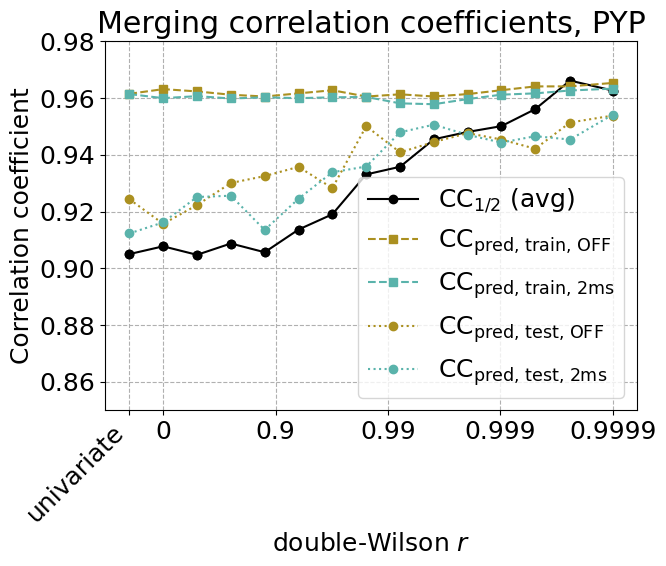

In [13]:
fig,ax = plt.subplots(figsize=(7,6))

plt.plot(np.log10(1-tmp["rDW"]),tmp["CChalf"],'ko-',label=r"CC$_\text{1/2}$ (avg)")
plt.plot(np.log10(1-tmp[tmp["delay"]==0]["rDW"]),tmp[tmp["delay"]==0]["CCpred_train"],'s--',color=pyp_yellow,label=r"CC$_\text{pred, train, OFF}$")
plt.plot(np.log10(1-tmp[tmp["delay"]==1]["rDW"]),tmp[tmp["delay"]==1]["CCpred_train"],'s--',color=pyp_blue,label=r"CC$_\text{pred, train, 2ms}$")
plt.plot(np.log10(1-tmp[tmp["delay"]==0]["rDW"]),tmp[tmp["delay"]==0]["CCpred_test"],'o:',color=pyp_yellow,label=r"CC$_\text{pred, test, OFF}$")
plt.plot(np.log10(1-tmp[tmp["delay"]==1]["rDW"]),tmp[tmp["delay"]==1]["CCpred_test"],'o:',color=pyp_blue,label=r"CC$_\text{pred, test, 2ms}$")

plt.grid(linestyle="--")
plt.title("Merging correlation coefficients, PYP")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-4,-3,-2,-1,0, 0.303],labels=["0.9999","0.999","0.99","0.9","0","univariate"])
#ax.set_yscale("log")
plt.ylim([0.85,0.98])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("figures/CCs.svg",bbox_inches="tight")
plt.show()

In [14]:
all_results.to_csv("careless_runs/all_results.csv")

### Ordinary difference map calculation

We then compute ordinary difference maps by subtracting the merged 2ms structure factors from the off structure factors. 

In [101]:
count=0
dir_list=[]
grid_id_list=[]
job_id_list=[] 
test_0_name="pyp_1p6A_grid_0.mtz"
search_pattern="\S*careless_runs\S*" # DONT FORGET TO UPDATE!

for dirpath, dirnames, filenames in os.walk("."):
    if (test_0_name in filenames) and (re.match(search_pattern, dirpath)):
        print(f"dir {count} has path: {dirpath}")
        dir_list.append(dirpath)
        try:
            tmp_grid_id=float(dirpath.split('_')[-1])
            tmp_job_id=float(dirpath.split('_')[-7]) #ADJUST AS APPROPRIATE
        except:
            pass # tbd
        grid_id_list.append(tmp_grid_id)
        job_id_list.append(tmp_job_id)
        count+=1

dir 0 has path: ./careless_runs/merge_21040353_6414_poly_mc1_50k_cl3_grid_16
dir 1 has path: ./careless_runs/merge_21040414_1740_poly_mc1_50k_cl3_grid_4
dir 2 has path: ./careless_runs/merge_21040418_16432_poly_mc1_50k_cl3_grid_8
dir 3 has path: ./careless_runs/merge_21040420_21111_poly_mc1_50k_cl3_grid_10
dir 4 has path: ./careless_runs/merge_21040355_26_poly_mc1_50k_cl3_grid_3
dir 5 has path: ./careless_runs/merge_21040537_31377_poly_mc1_50k_cl3_grid_12
dir 6 has path: ./careless_runs/merge_21040637_8951_poly_mc1_50k_cl3_grid_15
dir 7 has path: ./careless_runs/merge_21040415_28650_poly_mc1_50k_cl3_grid_5
dir 8 has path: ./careless_runs/merge_21040417_14369_poly_mc1_50k_cl3_grid_7
dir 9 has path: ./careless_runs/merge_21040419_9267_poly_mc1_50k_cl3_grid_9
dir 10 has path: ./careless_runs/merge_21040538_19944_poly_mc1_50k_cl3_grid_13
dir 11 has path: ./careless_runs/merge_21040354_27718_poly_mc1_50k_cl3_grid_2
dir 12 has path: ./careless_runs/merge_21040452_13926_poly_mc1_50k_cl3_grid_

In [102]:
delays=[0,1]
n_delays=2
mtz_base="pyp_1p6A_grid_"
my_dir=1

# for my_dir in dir_list:
print(dir_list[my_dir])

./careless_runs/merge_21040414_1740_poly_mc1_50k_cl3_grid_4


In [103]:
ds_off =rs.read_mtz(dir_list[my_dir]+'/'+mtz_base+str(delays[0])+".mtz")
ds_on  =rs.read_mtz(dir_list[my_dir]+'/'+mtz_base+str(delays[1])+".mtz")
diff_on_off = ds_off.merge(ds_on, left_index=True, right_index=True, suffixes=("_off", "_on"))

### Read in phases, FOM

In [104]:
ref=rs.read_mtz("ref/PYP_2PHY_ref34_phases.mtz")
ref.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 11784 entries, (0, 1, 2) to (35, 2, 2)
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype             
---  ------         --------------  -----             
 0   FOBS           11784 non-null  SFAmplitude       
 1   SIGFOBS        11784 non-null  Stddev            
 2   R_FREE_FLAGS   11784 non-null  MTZInt            
 3   FMODEL         11784 non-null  SFAmplitude       
 4   PHIFMODEL      11784 non-null  Phase             
 5   FCALC          11784 non-null  SFAmplitude       
 6   PHIFCALC       11784 non-null  Phase             
 7   FMASK          11784 non-null  SFAmplitude       
 8   PHIFMASK       11784 non-null  Phase             
 9   K_ISOTROPIC    11784 non-null  SFAmplitude       
 10  K_ANISOTROPIC  11784 non-null  SFAmplitude       
 11  K_MASK         11784 non-null  SFAmplitude       
 12  SIGK_MASK      11784 non-null  Stddev            
 13  FOM            11784 non-null  SFAmplitu

### Combining data and phases
**_Make sure that the reference model and the data are indexed consistently._**

In [105]:
combined_diff = diff_on_off.merge(ref, left_index=True, right_index=True, suffixes=("", "_ref"),check_isomorphous=False)
combined_diff.info()

<class 'reciprocalspaceship.dataset.DataSet'>
MultiIndex: 11327 entries, (0, 1, 2) to (35, 2, 1)
Data columns (total 43 columns):
 #   Column         Non-Null Count  Dtype             
---  ------         --------------  -----             
 0   F_off          11327 non-null  SFAmplitude       
 1   SigF_off       11327 non-null  Stddev            
 2   I_off          11327 non-null  Intensity         
 3   SigI_off       11327 non-null  Stddev            
 4   N_off          11327 non-null  MTZReal           
 5   high_off       11327 non-null  MTZReal           
 6   loc_off        11327 non-null  MTZReal           
 7   low_off        11327 non-null  MTZReal           
 8   scale_off      11327 non-null  MTZReal           
 9   F_on           11327 non-null  SFAmplitude       
 10  SigF_on        11327 non-null  Stddev            
 11  I_on           11327 non-null  Intensity         
 12  SigI_on        11327 non-null  Stddev            
 13  N_on           11327 non-null  MTZReal  

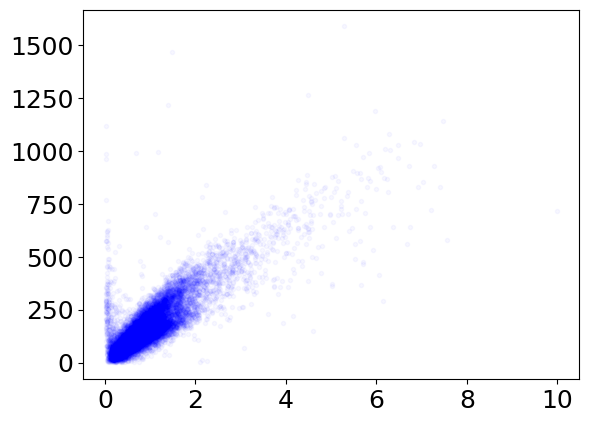

In [106]:
plt.plot(combined_diff["F_off"].to_numpy(),combined_diff["FCALC"].to_numpy(),'b.',alpha=0.03)
plt.show()

The reference and obsered structure factors should be well-correlated. 

We compute weights in a few different schemes, following Hekstra et al. 2016. In each weighting scheme, we weight $\sigma_{\Delta \text{F}}/\langle \sigma_{\Delta \text{F}} \rangle$ by $w_\sigma$ and the $|\Delta \text{F}| / \langle | \Delta \text{F}| \rangle$ term by $\alpha$. 

| weight label | $w_\sigma$ | $\alpha$|
|--------------|------------|----------------|
| `W_dh` |1 | 0.05 |
| `W_dh_b` |2 | 0.1 |
| `W_dh_c` |0.5 | 0.025 |
|`W_dh_d` |1 | 0 |
|`W_dh_e` |1 | 1 |

In [107]:
alpha=1.
# diff=combined_diff[["F_off", "SigF_off", "F_on", "SigF_on","FOM","FMODEL","FCALC","PHIFMODEL"]].copy()
diff=combined_diff[["F_off", "SigF_off", "F_on", "SigF_on","FCALC","PHIFCALC"]].copy()
diff.spacegroup=173
diff.cell=ref.cell
# diff["var_phi"]=2*(1-diff["FOM"])

diff["DeltaF"] = (diff['F_on'] - diff['F_off']).astype('F')
diff["SigDeltaF"] = np.sqrt(diff['SigF_on']**2. + diff['SigF_off']**2.).astype('Q')
diff["W_dh"] = ((1 + diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                 +0.05*np.abs(diff.DeltaF)**2/np.mean(np.abs(diff.DeltaF))**2.)**-1.).astype('W')

diff["W_dh_b"] = ((1 + 2*diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                 +0.1*np.abs(diff.DeltaF)**2/np.mean(np.abs(diff.DeltaF))**2.)**-1.).astype('W')

diff["W_dh_c"] = ((1 + 0.5*diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                 +0.025*np.abs(diff.DeltaF)**2/np.mean(np.abs(diff.DeltaF))**2.)**-1.).astype('W')

diff["W_dh_d"] = 1/(1 + diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)).astype('W')

diff["W_dh_e"] = ((1 + diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                 +np.abs(diff.DeltaF)/np.mean(np.abs(diff.DeltaF)))**-1.).astype('W')

In [108]:
merged_mtz_dir = "merged_mtzs/"
try:
    os.mkdir(merged_mtz_dir)
except:
    pass

fname_out=dir_list[my_dir].split('/')[-1] + "_2PHY_ref34.mtz"                   
print(fname_out)      
diff.write_mtz(merged_mtz_dir+fname_out)

merge_21040414_1740_poly_mc1_50k_cl3_grid_4_2PHY_ref34.mtz


Finally, we repeat this procedure for all datasets. Subsequent processing occurs in `PYP_diff_map_corr.ipynb`. 

In [109]:
for my_dir in range(len(dir_list)):
    ds_off =rs.read_mtz(dir_list[my_dir]+'/'+mtz_base+str(delays[0])+".mtz")
    ds_on  =rs.read_mtz(dir_list[my_dir]+'/'+mtz_base+str(delays[1])+".mtz")
    diff_on_off = ds_off.merge(ds_on, left_index=True, right_index=True, suffixes=("_off", "_on"))
    combined_diff = diff_on_off.merge(ref, left_index=True, right_index=True, suffixes=("", "_ref"),check_isomorphous=False)
    diff=combined_diff[["F_off", "SigF_off", "F_on", "SigF_on","FCALC","PHIFCALC"]].copy()
    diff.spacegroup=173
    diff.cell=ref.cell
    diff["DeltaF"] = (diff['F_on'] - diff['F_off']).astype('F')
    diff["SigDeltaF"] = np.sqrt(diff['SigF_on']**2. + diff['SigF_off']**2.).astype('Q')
    diff["W_dh"] = ((1 + diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                     +0.05*np.abs(diff.DeltaF)**2/np.mean(np.abs(diff.DeltaF))**2.)**-1.).astype('W')

    diff["W_dh_b"] = ((1 + 2*diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                     +0.1*np.abs(diff.DeltaF)**2/np.mean(np.abs(diff.DeltaF))**2.)**-1.).astype('W')

    diff["W_dh_c"] = ((1 + 0.5*diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                     +0.025*np.abs(diff.DeltaF)**2/np.mean(np.abs(diff.DeltaF))**2.)**-1.).astype('W')

    diff["W_dh_d"] = 1/(1 + diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)).astype('W')

    diff["W_dh_e"] = ((1 + diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                     +np.abs(diff.DeltaF)/np.mean(np.abs(diff.DeltaF)))**-1.).astype('W')
    diff["W_dh_f"] = ((1+np.abs(diff.DeltaF)/np.mean(np.abs(diff.DeltaF)))**-1.).astype('W')
    fname_out=dir_list[my_dir].split('/')[-1] + "_2PHY_ref34.mtz"                   
    print("wrote dataset ", fname_out)      
    diff.write_mtz(merged_mtz_dir+fname_out)

wrote dataset  merge_21040353_6414_poly_mc1_50k_cl3_grid_16_2PHY_ref34.mtz
wrote dataset  merge_21040414_1740_poly_mc1_50k_cl3_grid_4_2PHY_ref34.mtz
wrote dataset  merge_21040418_16432_poly_mc1_50k_cl3_grid_8_2PHY_ref34.mtz
wrote dataset  merge_21040420_21111_poly_mc1_50k_cl3_grid_10_2PHY_ref34.mtz
wrote dataset  merge_21040355_26_poly_mc1_50k_cl3_grid_3_2PHY_ref34.mtz
wrote dataset  merge_21040537_31377_poly_mc1_50k_cl3_grid_12_2PHY_ref34.mtz
wrote dataset  merge_21040637_8951_poly_mc1_50k_cl3_grid_15_2PHY_ref34.mtz
wrote dataset  merge_21040415_28650_poly_mc1_50k_cl3_grid_5_2PHY_ref34.mtz
wrote dataset  merge_21040417_14369_poly_mc1_50k_cl3_grid_7_2PHY_ref34.mtz
wrote dataset  merge_21040419_9267_poly_mc1_50k_cl3_grid_9_2PHY_ref34.mtz
wrote dataset  merge_21040538_19944_poly_mc1_50k_cl3_grid_13_2PHY_ref34.mtz
wrote dataset  merge_21040354_27718_poly_mc1_50k_cl3_grid_2_2PHY_ref34.mtz
wrote dataset  merge_21040452_13926_poly_mc1_50k_cl3_grid_11_2PHY_ref34.mtz
wrote dataset  merge_21040

for univariate MTZs that have been locally scaled, we then write the following: 

In [110]:
my_dir="./careless_runs/merge_21040353_6414_poly_mc1_50k_cl3_grid_16"
for mod in ["ls","scaled"]:

    ds_off =rs.read_mtz(my_dir+'/'+mtz_base+str(delays[0])+".mtz")
    ds_on  =rs.read_mtz(my_dir+'/'+mtz_base+str(delays[1])+"_"+mod+".mtz")
    diff_on_off = ds_off.merge(ds_on, left_index=True, right_index=True, suffixes=("_off", "_on"))
    combined_diff = diff_on_off.merge(ref, left_index=True, right_index=True, suffixes=("", "_ref"),check_isomorphous=False)
    diff=combined_diff[["F_off", "SigF_off", "F_on", "SigF_on","FCALC","PHIFCALC"]].copy()
    diff.spacegroup=173
    diff.cell=ref.cell
    diff["DeltaF"] = (diff['F_on'] - diff['F_off']).astype('F')
    diff["SigDeltaF"] = np.sqrt(diff['SigF_on']**2. + diff['SigF_off']**2.).astype('Q')
    diff["W_dh"] = ((1 + diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                     +0.05*np.abs(diff.DeltaF)**2/np.mean(np.abs(diff.DeltaF))**2.)**-1.).astype('W')

    diff["W_dh_b"] = ((1 + 2*diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                     +0.1*np.abs(diff.DeltaF)**2/np.mean(np.abs(diff.DeltaF))**2.)**-1.).astype('W')

    diff["W_dh_c"] = ((1 + 0.5*diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                     +0.025*np.abs(diff.DeltaF)**2/np.mean(np.abs(diff.DeltaF))**2.)**-1.).astype('W')

    diff["W_dh_d"] = 1/(1 + diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)).astype('W')

    diff["W_dh_e"] = ((1 + diff.SigDeltaF**2./np.mean(diff.SigDeltaF**2.)\
                     +np.abs(diff.DeltaF)/np.mean(np.abs(diff.DeltaF)))**-1.).astype('W')
    diff["W_dh_f"] = ((1+np.abs(diff.DeltaF)/np.mean(np.abs(diff.DeltaF)))**-1.).astype('W')
    fname_out=my_dir.split('/')[-1] + "_"+mod+"_2PHY_ref34.mtz"                   
    print("wrote dataset ", fname_out)      
    diff.write_mtz(merged_mtz_dir+fname_out)

wrote dataset  merge_21040353_6414_poly_mc1_50k_cl3_grid_16_ls_2PHY_ref34.mtz
wrote dataset  merge_21040353_6414_poly_mc1_50k_cl3_grid_16_scaled_2PHY_ref34.mtz


In [111]:
a = rs.read_mtz("merged_mtzs/merge_21040353_6414_poly_mc1_50k_cl3_grid_16_2PHY_ref34.mtz").acentrics

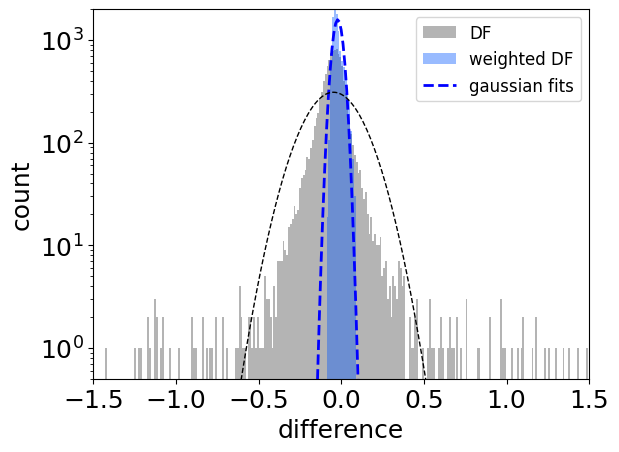

In [113]:
from scipy.stats import norm

fig, ax = plt.subplots()
wdf = a["W_dh_e"]*a["DeltaF"]

std = np.std(a["DeltaF"])
std_1 = np.std(wdf)

(mu_off, sigma_off) = norm.fit(a["DeltaF"])
(mu_on, sigma_on) = norm.fit(wdf)


#bin_centers = 0.5*(bins[1:]+bins[:-1])
#ax.plot(bin_centers,x,'-', label=f"200ns", color="#0055ff",linewidth=2)
x,bins,_ = ax.hist(a["DeltaF"],
                   alpha=0.4, bins=800, log=True,color="#444444", label=f"DF")
x, bins, _ =ax.hist(wdf,
                    alpha=0.4, bins=bins, log=True, color="#0055ff", label=f"weighted DF")
#bin_centers = 0.5*(bins[1:]+bins[:-1])
#ax.plot(bin_centers,x,'-', label=f"off",color="#444444",linewidth=2)
bin_width = bins[10]-bins[9]
y = norm.pdf(bins, mu_on, sigma_on)*len(wdf)*bin_width
l = ax.plot(bins, y, 'b--', linewidth=2, label="gaussian fits")
y = norm.pdf(bins, mu_off, sigma_off)*len(a["DeltaF"])*bin_width
l = ax.plot(bins, y, 'k--', linewidth=1)
ax.set_ylim([0.5,2e3])
ax.set_xlim([-1.5,1.5])
ax.set_xlabel("difference")
ax.set_ylabel("count")
plt.legend(fontsize=12)